## Photometry With MCMC

Having gotten the target files in the previous notebook, I'm going to now use the file `corecomposition/photometry.py` to fetch more photometry from either DES or PANSTARRS. Then, I'll run MCMC with a much better constraint on the temperature which will also give me a better constraint on the radius. 

First, I'll read in the gold, silver, and bronze samples. The gold and silver samples are both subsets of the bronze sample, so I'll do all of the analysis on the bronze table (since that will also analyze the stars in the gold and silver samples). 

In [1]:
### general
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('stefan.mplstyle')

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join, vstack, unique

### project-specific
import sys
sys.path.append('../')
sys.path.append('../../')
import corecomposition as cc
import WD_models

gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

It seems like most of the ground-based photometry is going to be contaminated by brighter field stars. That means that we'll have to 

In [2]:
vincent_class = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/A+A/682/A5/catalog.dat.gz')
classified = join(bronze, vincent_class, keys_left='wd_source_id', keys_right='GaiaDR3')

In [3]:
targets = vstack([gold, classified])
targets = unique(targets, keys='wd_source_id', keep='last')
ps_photo = cc.photometry.fetch_photometry(targets['wd_source_id'].data)
targets = join(targets, ps_photo, keys_left='wd_source_id', keys_right='source_id', join_type='outer')

In [4]:
targets[['wd_source_id', 'wd_phot_g_mean_mag', 'wd_ra', 'wd_dec', 'cmd_radius', 'SpType', 'source']]

wd_source_id,wd_phot_g_mean_mag,wd_ra,wd_dec,cmd_radius,SpType,source
int64,float64,float64,float64,float64,bytes3,str3
321259125631010688,19.23906898498535,17.00341481267388,35.814406111886065,0.007481759418545218,--,--
2153552814748001792,19.824588775634766,284.65870302124665,57.78819239158009,0.0067775427053977004,--,ps1
3090038517737811712,19.467735290527344,125.10155969827336,1.3826973946792267,0.007465250886754626,DA,ps1
3121385658671190784,17.237316131591797,92.21438403314589,-0.9974533046455966,0.004651617068459436,DA,ps1
3249027001465705088,18.224544525146484,53.713824909148926,-3.4247499092447784,0.007198684270318171,DA,ps1
4248619071266347648,19.120485305786133,301.35106967868836,5.137256051068365,0.007001884607420573,DA,ps1
4750614226039509888,18.58385467529297,46.49363872797763,-47.772247209794116,0.007177497308360124,DA,des
4762592584885748608,19.42276954650879,81.08108195558329,-59.947727725271655,0.0059727301554456215,--,--
5309155039065680512,19.6861629486084,144.35886329588214,-53.31675538451881,0.006532989105105616,--,--


In [5]:
with open('../data/cleaned/radius_chains_warwick_gaia.pkl', 'rb') as f:
    gaia_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hdef.pkl', 'rb') as f:
#    one_hdef_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hrich.pkl', 'rb') as f:
#    one_hrich_chains = pickle.load(f)

In [7]:
import sys
sys.path.append('../')
from corecomposition import interpolator
import corner
import pickle
from tqdm import tqdm

gaia_chains = {}
base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

for j in tqdm(range(len(targets['wd_source_id']))):
    source_id = targets['wd_source_id'][j]
    distance = targets['r_med_geo'][j]
    bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']
    photomet = np.array([targets['gmag_dereddened'], targets['bpmag_dereddened'], targets['rpmag_dereddened']]).T[j]
    e_photomet = np.array([targets['wd_e_gmag'], targets['wd_e_bpmag'], targets['wd_e_rpmag']]).T[j]
    initial_guess = [10000, 9]

    print(photomet, e_photomet, distance, initial_guess)

    gaia_model = interpolator.WarwickDAInterpolator(bands)
    # run the MCMC fit using one of the interpolators
    gaia_engine = interpolator.MCMCEngine(gaia_model)
    gaia_flat_chain = gaia_engine.run_mcmc(photomet, e_photomet, distance, initial_guess)
    gaia_chains[source_id] = gaia_flat_chain

with open('../data/cleaned/radius_chains_warwick_gaia.pkl', 'wb') as f:
    pickle.dump(gaia_chains, f)

  0%|          | 0/10 [00:00<?, ?it/s]

[19.23884907 19.3265868  19.24760651] [0.0046625  0.06271348 0.22759461] 167.5027618408203 [10000, 9]


In [45]:
source_ids = list(gaia_chains.keys())
radius_med = []
radius_low = []
radius_high = []

for wdid in source_ids:
    mcmc = np.percentile(gaia_chains[wdid][:,1],[16,50,84])
    unc = np.diff(mcmc)
    radius_med.append(mcmc[1])
    radius_low.append(unc[0])
    radius_high.append(unc[1])

radius_table = Table()
radius_table['wd_source_id'] = source_ids
radius_table['radius_med'] = radius_med
radius_table['radius_low'] = radius_low
radius_table['radius_high'] = radius_high

In [47]:
targets = join(targets, radius_table, keys='wd_source_id')

In [49]:
targets[['wd_source_id', 'wd_phot_g_mean_mag', 'wd_ra', 'wd_dec', 'cmd_radius', 'SpType', 'source', 'radius_med', 'radius_high', 'radius_low']]

wd_source_id,wd_phot_g_mean_mag,wd_ra,wd_dec,cmd_radius,SpType,source,radius_med,radius_high,radius_low
int64,float64,float64,float64,float64,bytes3,str3,float64,float64,float64
2153552814748001792,19.824588775634766,284.65870302124665,57.78819239158009,0.0067775427053977004,--,ps1,0.006524694432474702,0.0009655281882422345,0.0008684246309359402
3090038517737811712,19.467735290527344,125.10155969827336,1.3826973946792267,0.007465250886754626,DA,ps1,0.0076475889964418425,0.0005861209961903723,0.0006807305648442244
3121385658671190784,17.237316131591797,92.21438403314589,-0.9974533046455966,0.004651617068459436,DA,ps1,0.00474385038826994,6.806918635593549e-05,6.607407054453826e-05
3249027001465705088,18.224544525146484,53.713824909148926,-3.4247499092447784,0.007198684270318171,DA,ps1,0.007283477105129622,0.0002962724748178337,0.00032303547509792037
4248619071266347648,19.120485305786133,301.35106967868836,5.137256051068365,0.007001884607420573,DA,ps1,0.006732959490777837,0.0005046621327462839,0.00042490296822370564
4750614226039509888,18.58385467529297,46.49363872797763,-47.772247209794116,0.007177497308360124,DA,des,0.006843093113000025,0.00016992109897601398,0.00020817965013806596


In [ ]:
targets

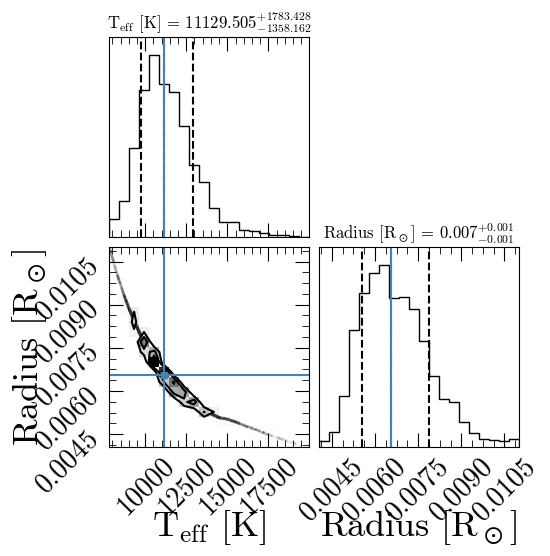

In [37]:
source = list(gaia_chains.keys())[9]
labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(gaia_chains[source][:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(gaia_chains[source], labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()